# Tests 20240118
- Previous test found that binary cross entropy loss did not work as well as FScore, so moving forward with FScore
- 4. Need to test hanning vs hamming window
- 3. Tested 0.05 window size, and 0.032 window size with the latter coming out slightly on top, need to plot spectrograms with 0.032 and see if there's a noteable difference
- 2. Manual dataset looks to be better than auto dataset, need to plot on same scale for both the 1st and 6th spectro runs
- 1. Auto dataset 6 didn't run last time, get that going

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
import os 
import glob
import csv
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as confusion_matrix_sklearn

from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.data_handling.data_feeding import BatchGenerator
from ketos.neural_networks.resnet import ResNetInterface
from ketos.audio.audio_loader import AudioFrameLoader, AudioLoader, SelectionTableIterator
from ketos.audio.spectrogram import MagSpectrogram
from ketos.neural_networks.dev_utils.detection import batch_load_audio_file_data, filter_by_threshold
from ketos.data_handling.data_feeding import JointBatchGen

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('done importing packages')

done importing packages


C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Train auto-6

In [7]:
recipe = r'E:\tests\tests-20240116\recipe-files\resnet_recipe-1.json'

spectro_test_folder = r'E:\tests\tests-20240118\auto-6'

# one: 100 to 1200 (usual)
# two: 0 to 1500
# three: 0 to 3000
# four: usual, rate 2000
# five: usual, rate 4000
# six: usual, window 0.032 ** ERROR, 2000, 0-3000, 0.032. TOO MANY THINGS CHANGED

db_names = r'E:\tests\tests-20240116\1sec-auto\recipe-1\spectro-6-db.h5'

model_names = spectro_test_folder + '\\' + 'rs-spec6.kt'

temp_folders = spectro_test_folder + '\\' + 'rs-temp-6'

In [10]:
spec_file = r'E:\tests\tests-20240116\spectro-files\spec_config_6.json'

# join into a database
# Load the spectrogram representation & parameters, this returns a dict 
spec_cfg = load_audio_representation(spec_file, name="spectrogram")

# Set the random seed for numpy and tensorflow 
np.random.seed(1000)
tf.random.set_seed(2000)

# Set the batch size and number of epochs for training
batch_size = 16
n_epochs = 40

# Set the log folder and checkpoint folder 
log_folder = spectro_test_folder + '\\' + 'logs'
checkpoint_folder = spectro_test_folder + '\\' + 'checkpoints'

# Open the database file in read mode
db = dbi.open_file(db_names, 'r')

# Open the training and validation tables respectively 
train_data = dbi.open_table(db, "/train/data")
val_data = dbi.open_table(db, "/val/data")

# Create batches of training data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                    output_transform_func=ResNetInterface.transform_batch,
                                    shuffle=True, refresh_on_epoch_end=True)

# Create batches of validation data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                   output_transform_func=ResNetInterface.transform_batch,
                                   shuffle=False, refresh_on_epoch_end=False)

# Build the ResNet model file based off of the recipe file - this creates a "ResNetInterface" object 
resnet = ResNetInterface.build(recipe)

# Set the training and validation generators to the batch generators created above 
resnet.train_generator = train_generator
resnet.val_generator = val_generator

# Set the model log and checkpoint directory 
resnet.log_dir = log_folder
resnet.checkpoint_dir = checkpoint_folder

# Train the model, looping through all of the training and validation data 
# See code map for more information
resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log.csv')

# Close the database 
db.close()

# Save the model file, and keep track of the spectrogram parameters used to generate that model 
resnet.save(model_names, audio_repr_file=spec_file)

print('Done')

NameError: name 'idex' is not defined

## Plot manual vs auto results for 1 and 6

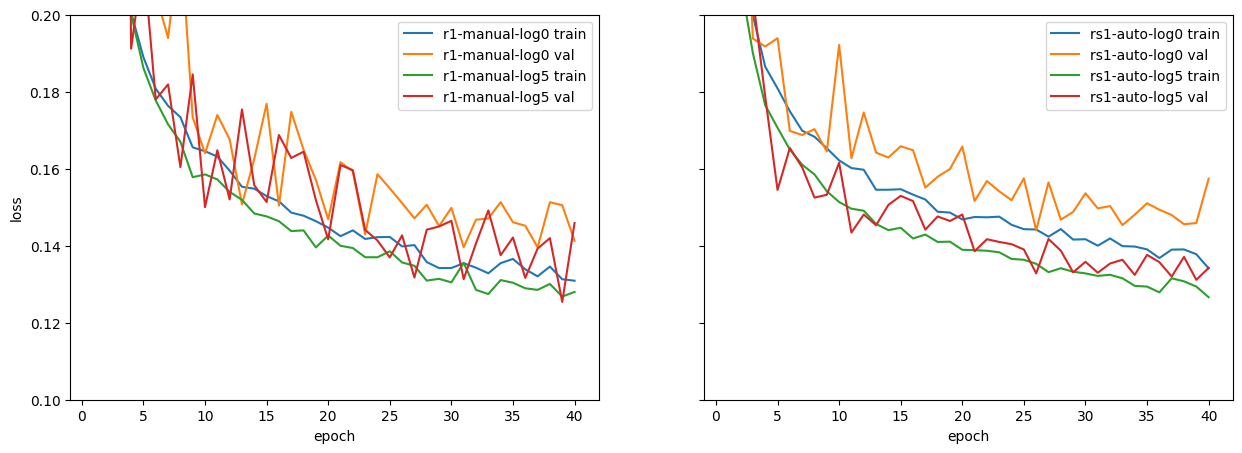

In [54]:
# Get path to folder containing logs 
log_folder = r'E:\tests\tests-20240118\auto-6\logs'

files = glob.glob(log_folder  + "/*.csv")

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
axes[0].set_ylim(0.1, 0.20)

for file in files:

    # Read the log file 
    log_file = pd.read_csv(file)

    labell = file.split('\\')[-1].split(".")[0]
    
    # Get the training and validation losses 
    tr_results = log_file[log_file['dataset']=='train']
    va_results = log_file[log_file['dataset']=='val']

    if 'manual' in labell:

        sns.lineplot(ax=axes[0], data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
        sns.lineplot(ax=axes[0], data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto')  

    if 'auto' in labell: 

        sns.lineplot(ax=axes[1], data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
        sns.lineplot(ax=axes[1], data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto') 


The left plot shows the manual dataset results and the right plot shows the auto dataset results.
- Spectro 5 does better than spectro 1 in both training and validation
- For log 5, the manual dataset and auto dataset have similar loss curves with the manual dataset train performing slightly better, but the validation being worse than the auto dataset

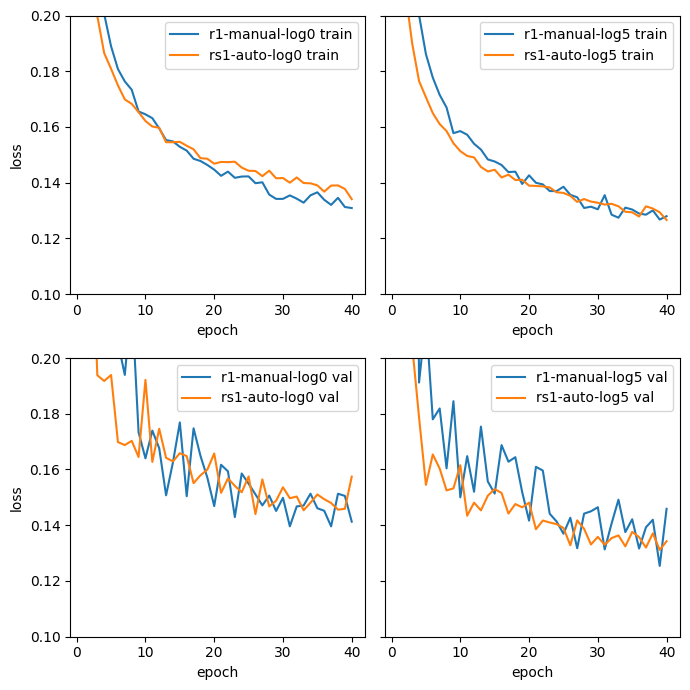

In [57]:
# Get path to folder containing logs 
log_folder = r'E:\tests\tests-20240118\auto-6\logs'

files = glob.glob(log_folder  + "/*.csv")

fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharey=True)

for file in files:

    # Read the log file 
    log_file = pd.read_csv(file)

    labell = file.split('\\')[-1].split(".")[0]
    
    # Get the training and validation losses 
    tr_results = log_file[log_file['dataset']=='train']
    va_results = log_file[log_file['dataset']=='val']

    if 'log0' in labell:

        sns.lineplot(ax=axes[0, 0], data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
        sns.lineplot(ax=axes[1, 0], data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto') 
        axes[0, 1].set_ylim(0.1, 0.20)

    if 'log5' in labell:

        sns.lineplot(ax=axes[0, 1], data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
        sns.lineplot(ax=axes[1, 1], data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto') 

plt.tight_layout()
     

From the above plots, we can see that for spectro 1 (0.05 window) the manual dataset results in smaller loss for training. For spectro 6 (window 0.032), the manual and auto datasets perform almost identically.

## Plot example of spectrograms with both recipe files

In [84]:
def load_audio_seg(annot_file, spec_file, data_dir):
    """
    Plot spectrograms for review
    :param annot_file: annotation file (xlsx)
    :param spec_file: spectrogram file
    :param data_dir: directory where data is stored (main level)
    :return:
    """

    annot = pd.read_csv(annot_file)

    # something up with loading in the spectro file
    f = open(spec_file)
    spec_info = json.load(f)
    rep = spec_info['spectrogram']

    # deal with merging of cells in the annotations table
    for ii in range(0, len(annot)):
        if type(annot.loc[ii][0]) == str:
            filename = annot.loc[ii][0]
        else:
            filename = annot['filename'][ii]

    # standardize tables
    annot = annot.ffill()
    annot_std = sl.standardize(table=annot)
    print('table standardized? ' + str(sl.is_standardized(annot_std)))

    # define spectrogram generation parameters
    spec_par = sl.select(annotations=annot_std, length=1.0, step=1, min_overlap=1, center=False)

    # create a generator for iterating over all the selections
    generator = SelectionTableIterator(data_dir=data_dir, selection_table=spec_par)

    # Create a loader by passing the generator and the representation to the AudioLoader
    loader = AudioLoader(selection_gen=generator, representation=MagSpectrogram, representation_params=rep, pad=False)

    # print number of segments
    print('Total number of segments is ' + str(loader.num()))
    annots = float(loader.num())

    return annots, loader


def plot_spectrogram(annot, loader, output_dir):
    """
    Plots spectrograms from an audioLoader item, call load_audio_seg first
    :param annot: annotation table returned from load_audio_seg
    :param loader: audioloader returned from load_audio_seg
    :param output_dir: output path to where you want the image saved
    :return:
    """

    for ii in range(0, 5):
            spec = next(loader)
            if ii==4:
                fig = spec.plot()
                path = output_dir
                figname = path + "\\" + str(ii) + '.png'
                #fig.savefig(figname)
                plt.show()
                plt.close()

table standardized? True
Total number of segments is 1476
1476.0


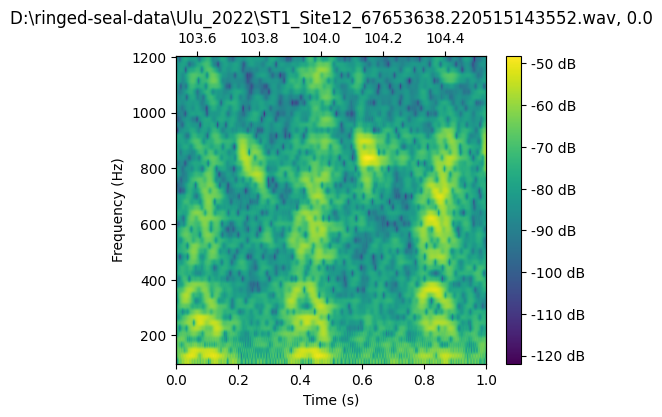

table standardized? True
Total number of segments is 1476
1476.0


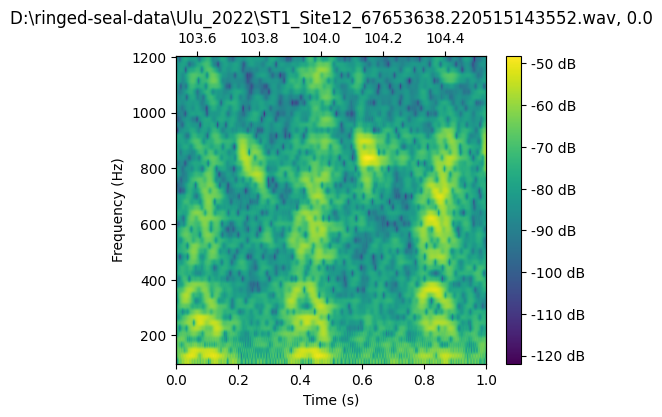

In [85]:
spectro_folder = r'E:\tests\tests-20240118\spectro_files'
spectro_files = glob.glob(spectro_folder  + "/*.json")

annot_file = r'E:\tests\tests-20240118\ULU2022_all_formatted_1sec.csv'
output_dir = r'E:\tests\tests-20240118\spectro'
data_dir = r'D:\ringed-seal-data'

for spec_file in spectro_files:

    # create an audioloader with the spectrograms
    # note you need to define step, maximum overlap, and length in this step
    annot, loader = load_audio_seg(annot_file, spec_file, data_dir)

    print(annot)

    # take audio segments and create spectrogram representation
    fig = plot_spectrogram(annot, loader, output_dir)
    plt.show()

From the above, we can see visually there are very minor differences between the two spectrograms, which is interesting because the window size did affect the results slighty. 

Going forward, I will continue to use recipe 1, spectro 5 (0.032 window), and test both the manual and auto dataset models.

## Test Hanning vs Hamming Window

table standardized? True
Total number of segments is 1476
1476.0


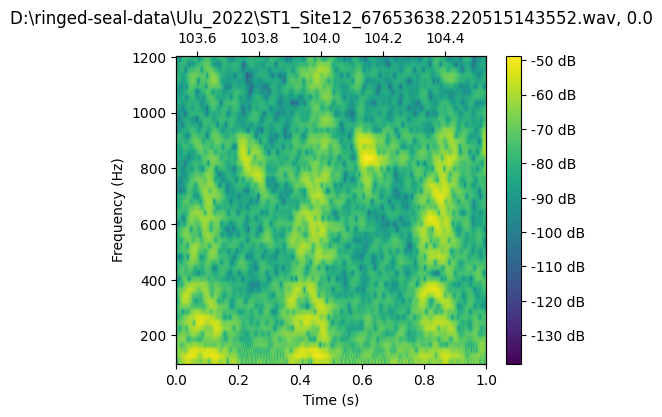

table standardized? True
Total number of segments is 1476
1476.0


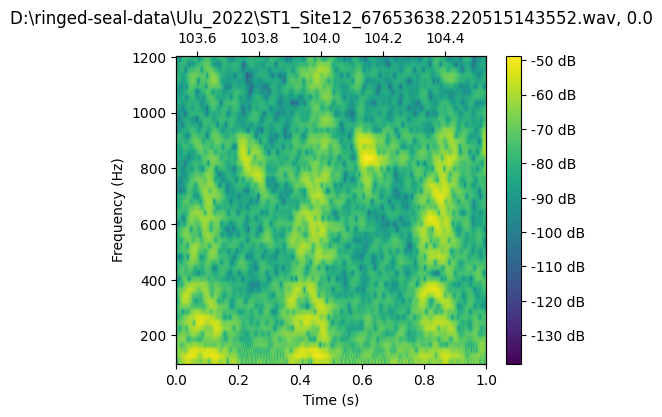

In [79]:
spectro_folder = r'E:\tests\tests-20240118\spectro-hann'
spectro_files = glob.glob(spectro_folder  + "/*.json")

annot_file = r'E:\tests\tests-20240118\ULU2022_all_formatted_1sec.csv'
output_dir = r'E:\tests\tests-20240118\spectro'
data_dir = r'D:\ringed-seal-data'

for spec_file in spectro_files:

    # create an audioloader with the spectrograms
    # note you need to define step, maximum overlap, and length in this step
    annot, loader = load_audio_seg(annot_file, spec_file, data_dir)

    print(annot)

    # take audio segments and create spectrogram representation
    fig = plot_spectrogram(annot, loader, output_dir)
    plt.show()

Run a model for hanning window, spectro 0.032, both manual and auto dataset:

### Manual

In [142]:
pos_folder = r'E:\tests\1sec-manual\inputs\annots\pos'

# Get list of all csv files in that folder
files_pos = glob.glob(pos_folder + "/*.csv")

site_names = []
num_annots = []

# For each csv file
for file in files_pos:

    annots = pd.read_csv(file)

    site_name = file.split('\\')[-1].split('.')[0].split('_')[0]

    site_names.append(site_name)
    num_annots.append(len(annots))

ULU22_val = num_annots[site_names.index('ULU2022')]
other_val = sum(num_annots) - ULU22_val
all_annots = sum(num_annots)

ulu_2022_split = 0.32
all_else_split = 1 - ulu_2022_split

dataset_split = [0.7, 0.2, 0.1]

train_annots = round(all_annots*dataset_split[0])
val_annots = round(all_annots*dataset_split[1])
test_annots = round(all_annots*dataset_split[2])

# ulu22 vals
ulu22_tr = round(train_annots*ulu_2022_split)
ulu22_va = round(val_annots*ulu_2022_split)
ulu22_te = round(test_annots*ulu_2022_split)

ulu22_leftovers = ULU22_val - ulu22_tr - ulu22_va - ulu22_te

if ulu22_leftovers < 0:
    ulu22_te = ulu22_te + ulu22_leftovers

if ulu22_leftovers > 0 :
    ulu22_tr = ulu22_tr + ulu22_leftovers

all_ulu = ulu22_tr + ulu22_te + ulu22_va

if all_ulu != ULU22_val:
    print('Something went wrong with Ulu')
    exit()

ulu2022_vals = [ulu22_tr, ulu22_va, ulu22_te]

# rest vals
rest_tr = round(train_annots*all_else_split)
rest_va = round(val_annots*all_else_split)
rest_te = round(test_annots*all_else_split)

# totals
all_added = rest_tr + rest_va + rest_te

if all_added < other_val:
    leftover = other_val - all_added
    rest_tr = rest_tr + leftover

if all_added > other_val:
    leftover = all_added - other_val
    rest_va = rest_va - leftover

all_added2 = rest_tr + rest_va + rest_te

cb_perc = num_annots[0]/all_added2
kk_perc = num_annots[1]/all_added2
ulu_perc = num_annots[4]/all_added2

# split into other site vals
cb_tr = round(cb_perc*rest_tr)
cb_va = round(cb_perc*rest_va)
cb_te = round(cb_perc*rest_te)
total_cb = cb_tr + cb_va + cb_te
if total_cb < num_annots[0]:
    leftover_cb = num_annots[0] - total_cb
    cb_tr = cb_tr + leftover_cb
if total_cb > num_annots[0]:
    leftover_cb = num_annots[0] - total_cb
    cb_va = cb_va + leftover_cb
cb_vals = [cb_tr, cb_va, cb_te]

kk_tr = round(kk_perc*rest_tr)
kk_va = round(kk_perc*rest_va)
kk_te = round(kk_perc*rest_te)
total_kk = kk_tr + kk_va + kk_te
if total_kk < num_annots[1]:
    leftover_kk = num_annots[1] - total_kk
    kk_tr = kk_tr + leftover_kk
if total_kk > num_annots[1]:
    leftover_kk = num_annots[1] - total_kk
    kk_va = kk_va + leftover_kk
kk_vals = [kk_tr, kk_va, kk_te]
    
ulu_tr = round(ulu_perc*rest_tr)
ulu_va = round(ulu_perc*rest_va)
ulu_te = round(ulu_perc*rest_te)
total_ulu = ulu_tr + ulu_va + ulu_te
if total_ulu < num_annots[4]:
    leftover_ulu = num_annots[4] - total_ulu
    ulu_tr = ulu_tr + leftover_ulu
if total_ulu > num_annots[4]:
    leftover_ulu = num_annots[4] - total_ulu
    ulu_va = ulu_va + leftover_ulu
ulu_vals = [ulu_tr, ulu_va, ulu_te]

print('ulu22 vals (tr, va, te): ' + str(ulu2022_vals) + ', total: ' + str(sum(ulu2022_vals)))
print('ulu vals (tr, va, te): ' + str(ulu_vals) + ', total: ' + str(sum(ulu_vals)))
print('kk vals (tr, va, te): ' + str(kk_vals) + ', total: ' + str(sum(kk_vals)))
print('cb vals (tr, va, te): ' + str(cb_vals) + ', total: ' + str(sum(cb_vals)))

ulu22 vals (tr, va, te): [1037, 296, 143], total: 1476
ulu vals (tr, va, te): [669, 191, 95], total: 955
kk vals (tr, va, te): [1348, 384, 192], total: 1924
cb vals (tr, va, te): [133, 38, 19], total: 190


In [143]:
# Load in user inputs 
main_folder = r'E:\tests\tests-20240118\spectro-hann'

# These are copied from the 2sec edited folder 
neg_folder = r'E:\tests\1sec-manual\inputs\annots\neg'
pos_folder = r'E:\tests\1sec-manual\inputs\annots\pos'

file_durations_file = r'E:\tests\all_file_durations_complete.xlsx'
file_durations = pd.read_excel(file_durations_file)

data_folder = r'D:\ringed-seal-data'

In [144]:
## Create Database ##

# negatives tables and standarize for ketos
ulu_neg = pd.read_excel(neg_folder + '\\' + 'ULU-negs-joined.xlsx')
ulu_neg = ulu_neg.ffill()
ulu_neg = sl.standardize(table=ulu_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu_neg)))

ulu2022_neg = pd.read_excel(neg_folder + '\\' + 'ULU2022-negs-joined.xlsx')
ulu2022_neg = ulu2022_neg.ffill()
ulu2022_neg = sl.standardize(table=ulu2022_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu2022_neg)))

kk_neg = pd.read_excel(neg_folder + '\\' + 'KK-negs-joined.xlsx')
kk_neg = kk_neg.ffill()
kk_neg = sl.standardize(table=kk_neg)
print('Negatives standardized? ' + str(sl.is_standardized(kk_neg)))

cb_neg = pd.read_excel(neg_folder + '\\' + 'CB-negs-joined.xlsx')
cb_neg = cb_neg.ffill()
cb_neg = sl.standardize(table=cb_neg)
print('Negatives standardized? ' + str(sl.is_standardized(cb_neg)))

# positives tables
ulu_pos = pd.read_csv(pos_folder + '\\' + 'ULU_all_formatted_1sec.csv')
ulu_pos = ulu_pos.ffill()
ulu_pos = sl.standardize(table=ulu_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu_pos)))

ulu2022_pos = pd.read_csv(pos_folder + '\\' + 'ULU2022_all_formatted_1sec.csv')
ulu2022_pos = ulu2022_pos.ffill()
ulu2022_pos = sl.standardize(table=ulu2022_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu2022_pos)))

kk_pos = pd.read_csv(pos_folder + '\\' + 'KK_all_formatted_1sec.csv')
kk_pos = kk_pos.ffill()
kk_pos = sl.standardize(table=kk_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(kk_pos)))

cb_pos = pd.read_csv(pos_folder + '\\' + 'CB_all_formatted_1sec.csv')
cb_pos = cb_pos.ffill()
cb_pos = sl.standardize(table=cb_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(cb_pos)))

# join into complete tables

ulu_pos_tr = ulu_pos.head(ulu_vals[0])
ulu_pos_va = ulu_pos[ulu_vals[0]:ulu_vals[0] + ulu_vals[1]]
ulu_pos_te = ulu_pos.tail(ulu_vals[2])

ulu_neg_tr = ulu_neg.head(ulu_vals[0])
ulu_neg_va = ulu_neg[ulu_vals[0]:ulu_vals[0] + ulu_vals[1]]
ulu_neg_te = ulu_neg.tail(ulu_vals[2])

ulu_tr = pd.concat([ulu_pos_tr, ulu_neg_tr])
ulu_va = pd.concat([ulu_pos_va, ulu_neg_va])
ulu_te = pd.concat([ulu_pos_te, ulu_neg_te])

ulu2022_pos_tr = ulu2022_pos.head(ulu2022_vals[0])
ulu2022_pos_va = ulu2022_pos[ulu2022_vals[0]:ulu2022_vals[0] + ulu2022_vals[1]]
ulu2022_pos_te = ulu2022_pos.tail(ulu2022_vals[2])

ulu2022_neg_tr = ulu2022_neg.head(ulu2022_vals[0])
ulu2022_neg_va = ulu2022_neg[ulu2022_vals[0]:ulu2022_vals[0] + ulu2022_vals[1]]
ulu2022_neg_te = ulu2022_neg.tail(ulu2022_vals[2])

ulu2022_tr = pd.concat([ulu2022_pos_tr, ulu2022_neg_tr])
ulu2022_va = pd.concat([ulu2022_pos_va, ulu2022_neg_va])
ulu2022_te = pd.concat([ulu2022_pos_te, ulu2022_neg_te])

kk_pos_tr = kk_pos.head(kk_vals[0])
kk_pos_va = kk_pos[kk_vals[0]:kk_vals[0] + kk_vals[1]]
kk_pos_te = kk_pos.tail(kk_vals[2])

kk_neg_tr = kk_neg.head(kk_vals[0])
kk_neg_va = kk_neg[kk_vals[0]:kk_vals[0] + kk_vals[1]]
kk_neg_te = kk_neg.tail(kk_vals[2])

kk_tr = pd.concat([kk_pos_tr, kk_neg_tr])
kk_va = pd.concat([kk_pos_va, kk_neg_va])
kk_te = pd.concat([kk_pos_te, kk_neg_te])

cb_pos_tr = cb_pos.head(cb_vals[0])
cb_pos_va = cb_pos[cb_vals[0]:cb_vals[0] + cb_vals[1]]
cb_pos_te = cb_pos.tail(cb_vals[2])

cb_neg_tr = cb_neg.head(cb_vals[0])
cb_neg_va = cb_neg[cb_vals[0]:cb_vals[0] + cb_vals[1]]
cb_neg_te = cb_neg.tail(cb_vals[2])

cb_tr = pd.concat([cb_pos_tr, cb_neg_tr])
cb_va = pd.concat([cb_pos_va, cb_neg_va])
cb_te = pd.concat([cb_pos_te, cb_neg_te])

# final three tables

train = pd.concat([ulu_tr, ulu2022_tr, cb_tr, kk_tr])
val = pd.concat([ulu_va, ulu2022_va, cb_va, kk_va])
test = pd.concat([ulu_te, ulu2022_te, cb_te, kk_te])

Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True


In [145]:
def drop_rows(file_durations, table):

    drop = []

    print('cleaning training table of original length ' + str(len(table)))

    for idex, row in table.iterrows():
    
        # filename is row[0], end time is idex.end
        index = file_durations.loc[file_durations['filename'] == row.name[0]].index
        duration = file_durations['duration'][index].values[0]
    
        if duration < row.end:
            # drop the row corresponding to that sel_id and filename from the dataframe
            drop.append(idex)
    
        if row.start < 0:
            drop.append(idex)
    
    print('Number of rows to drop (note, one entry may be in list twice): ' + str(len(drop)))

    return drop

In [146]:
drop_rows_tr = drop_rows(file_durations, train)
train = train.drop(drop_rows_tr)
print(len(train))

cleaning training table of original length 6374
Number of rows to drop (note, one entry may be in list twice): 10
6362


In [147]:
drop_rows_va = drop_rows(file_durations, val)
val = val.drop(drop_rows_va)
print(len(val))

cleaning training table of original length 1818
Number of rows to drop (note, one entry may be in list twice): 4
1813


In [148]:
drop_rows_te = drop_rows(file_durations, test)
test = test.drop(drop_rows_te)
print(len(test))

cleaning training table of original length 898
Number of rows to drop (note, one entry may be in list twice): 2
894


In [149]:
spectro_file = r'E:\tests\tests-20240118\spectro-hann\spec_config_100-1200Hz-0.03-hamm.json'
recipe = r'E:\tests\recipe-files\resnet_recipe-1.json'
main_folder = r'E:\tests\tests-20240118\spectro-hann'
db_name = main_folder + '\\' + 'hamm-manual.h5'
model_name = main_folder + '\\' + 'rs-hamm-manual.kt'
temp_folder = main_folder + '\\' + 'rs-temp-1-hamm-manual'

In [150]:
# join into a database
# Load the spectrogram representation & parameters, this returns a dict 
spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

# Create a table called "train" in the database, defined by db_name, using the "train" selections table, the spectrogram config, and the audio data 
# Behind the hood, this creates an AudioLoader and AudioWriter Ketos function which generates the spectrograms for each selection 
# For the specific spectrogram in this case, the spectrograms are of size [1500,56] where 56 refers to the frequency dimension and 1500 refers to the time dimension 
# The size of the spectrogram is 1500*56, which is 84000
dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'train', selections=train, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'val', selections=val, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'test', selections=test, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|██████████████████████████████████████████████████████████████████████████████| 6362/6362 [02:53<00:00, 36.72it/s]


6362 items saved to E:\tests\tests-20240118\spectro-hann\hamm-manual.h5


100%|██████████████████████████████████████████████████████████████████████████████| 1813/1813 [00:44<00:00, 40.48it/s]


1813 items saved to E:\tests\tests-20240118\spectro-hann\hamm-manual.h5


100%|████████████████████████████████████████████████████████████████████████████████| 894/894 [00:22<00:00, 39.98it/s]

894 items saved to E:\tests\tests-20240118\spectro-hann\hamm-manual.h5


In [151]:
# Set the random seed for numpy and tensorflow 
np.random.seed(1000)
tf.random.set_seed(2000)

# Set the batch size and number of epochs for training
batch_size = 16
n_epochs = 40

# Set the log folder and checkpoint folder 
log_folder = main_folder + '\\' + 'logs'
checkpoint_folder = main_folder + '\\' + 'checkpoints'

# Open the database file in read mode
db = dbi.open_file(db_name, 'r')

# Open the training and validation tables respectively 
train_data = dbi.open_table(db, "/train/data")
val_data = dbi.open_table(db, "/val/data")

# Create batches of training data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                    output_transform_func=ResNetInterface.transform_batch,
                                    shuffle=True, refresh_on_epoch_end=True)

# Create batches of validation data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                   output_transform_func=ResNetInterface.transform_batch,
                                   shuffle=False, refresh_on_epoch_end=False)

# Build the ResNet model file based off of the recipe file - this creates a "ResNetInterface" object 
resnet = ResNetInterface.build(recipe)

# Set the training and validation generators to the batch generators created above 
resnet.train_generator = train_generator
resnet.val_generator = val_generator

# Set the model log and checkpoint directory 
resnet.log_dir = log_folder
resnet.checkpoint_dir = checkpoint_folder

# Train the model, looping through all of the training and validation data 
# See code map for more information
resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log.csv')

# Close the database 
db.close()

# Save the model file, and keep track of the spectrogram parameters used to generate that model 
resnet.save(model_name, audio_repr_file=spec_file)

print('Done')

Done


### Auto

In [152]:
pos_folder = r'E:\tests\tests-20240116\1sec-auto\inputs\annots\pos'

# Get list of all csv files in that folder
files_pos = glob.glob(pos_folder + "/*.csv")

site_names = []
num_annots = []

# For each csv file
for file in files_pos:

    annots = pd.read_csv(file)

    site_name = file.split('\\')[-1].split('.')[0].split('_')[0]

    site_names.append(site_name)
    num_annots.append(len(annots))

ULU22_val = num_annots[site_names.index('ULU2022')]
other_val = sum(num_annots) - ULU22_val
all_annots = sum(num_annots)

ulu_2022_split = 0.32
all_else_split = 1 - ulu_2022_split

dataset_split = [0.7, 0.2, 0.1]

train_annots = round(all_annots*dataset_split[0])
val_annots = round(all_annots*dataset_split[1])
test_annots = round(all_annots*dataset_split[2])

# ulu22 vals
ulu22_tr = round(train_annots*ulu_2022_split)
ulu22_va = round(val_annots*ulu_2022_split)
ulu22_te = round(test_annots*ulu_2022_split)

ulu22_leftovers = ULU22_val - ulu22_tr - ulu22_va - ulu22_te

if ulu22_leftovers < 0:
    ulu22_te = ulu22_te + ulu22_leftovers

if ulu22_leftovers > 0 :
    ulu22_tr = ulu22_tr + ulu22_leftovers

all_ulu = ulu22_tr + ulu22_te + ulu22_va

if all_ulu != ULU22_val:
    print('Something went wrong with Ulu')
    exit()

ulu2022_vals = [ulu22_tr, ulu22_va, ulu22_te]

# rest vals
rest_tr = round(train_annots*all_else_split)
rest_va = round(val_annots*all_else_split)
rest_te = round(test_annots*all_else_split)

# totals
all_added = rest_tr + rest_va + rest_te

if all_added < other_val:
    leftover = other_val - all_added
    rest_tr = rest_tr + leftover

if all_added > other_val:
    leftover = all_added - other_val
    rest_va = rest_va - leftover

all_added2 = rest_tr + rest_va + rest_te

cb_perc = num_annots[0]/all_added2
kk_perc = num_annots[1]/all_added2
ulu_perc = num_annots[4]/all_added2

# split into other site vals
cb_tr = round(cb_perc*rest_tr)
cb_va = round(cb_perc*rest_va)
cb_te = round(cb_perc*rest_te)
total_cb = cb_tr + cb_va + cb_te
if total_cb < num_annots[0]:
    leftover_cb = num_annots[0] - total_cb
    cb_tr = cb_tr + leftover_cb
if total_cb > num_annots[0]:
    leftover_cb = num_annots[0] - total_cb
    cb_va = cb_va + leftover_cb
cb_vals = [cb_tr, cb_va, cb_te]

kk_tr = round(kk_perc*rest_tr)
kk_va = round(kk_perc*rest_va)
kk_te = round(kk_perc*rest_te)
total_kk = kk_tr + kk_va + kk_te
if total_kk < num_annots[1]:
    leftover_kk = num_annots[1] - total_kk
    kk_tr = kk_tr + leftover_kk
if total_kk > num_annots[1]:
    leftover_kk = num_annots[1] - total_kk
    kk_va = kk_va + leftover_kk
kk_vals = [kk_tr, kk_va, kk_te]
    
ulu_tr = round(ulu_perc*rest_tr)
ulu_va = round(ulu_perc*rest_va)
ulu_te = round(ulu_perc*rest_te)
total_ulu = ulu_tr + ulu_va + ulu_te
if total_ulu < num_annots[4]:
    leftover_ulu = num_annots[4] - total_ulu
    ulu_tr = ulu_tr + leftover_ulu
if total_ulu > num_annots[4]:
    leftover_ulu = num_annots[4] - total_ulu
    ulu_va = ulu_va + leftover_ulu
ulu_vals = [ulu_tr, ulu_va, ulu_te]

print('ulu22 vals (tr, va, te): ' + str(ulu2022_vals) + ', total: ' + str(sum(ulu2022_vals)))
print('ulu vals (tr, va, te): ' + str(ulu_vals) + ', total: ' + str(sum(ulu_vals)))
print('kk vals (tr, va, te): ' + str(kk_vals) + ', total: ' + str(sum(kk_vals)))
print('cb vals (tr, va, te): ' + str(cb_vals) + ', total: ' + str(sum(cb_vals)))

ulu22 vals (tr, va, te): [2266, 647, 262], total: 3175
ulu vals (tr, va, te): [1568, 442, 221], total: 2231
kk vals (tr, va, te): [2874, 811, 405], total: 4090
cb vals (tr, va, te): [294, 83, 41], total: 418


In [153]:
# Load in user inputs 
main_folder = r'E:\tests\tests-20240118\spectro-hann'

# These are copied from the 2sec edited folder 
neg_folder = r'E:\tests\tests-20240116\1sec-auto\inputs\annots\neg'
pos_folder = r'E:\tests\tests-20240116\1sec-auto\inputs\annots\pos'

file_durations_file = r'E:\tests\all_file_durations_complete.xlsx'
file_durations = pd.read_excel(file_durations_file)

data_folder = r'D:\ringed-seal-data'

In [154]:
## Create Database ##

# negatives tables and standarize for ketos
ulu_neg = pd.read_csv(neg_folder + '\\' + 'ULU_all_formatted_shifted_negatives.csv')
ulu_neg = ulu_neg.ffill()
ulu_neg = sl.standardize(table=ulu_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu_neg)))

ulu2022_neg = pd.read_csv(neg_folder + '\\' + 'ULU2022_all_formatted_shifted_negatives.csv')
ulu2022_neg = ulu2022_neg.ffill()
ulu2022_neg = sl.standardize(table=ulu2022_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu2022_neg)))

kk_neg = pd.read_csv(neg_folder + '\\' + 'KK_all_formatted_shifted_negatives.csv')
kk_neg = kk_neg.ffill()
kk_neg = sl.standardize(table=kk_neg)
print('Negatives standardized? ' + str(sl.is_standardized(kk_neg)))

cb_neg = pd.read_csv(neg_folder + '\\' + 'CB_all_formatted_shifted_negatives.csv')
cb_neg = cb_neg.ffill()
cb_neg = sl.standardize(table=cb_neg)
print('Negatives standardized? ' + str(sl.is_standardized(cb_neg)))

# positives tables
ulu_pos = pd.read_csv(pos_folder + '\\' + 'ULU_all_formatted_shifted.csv')
ulu_pos = ulu_pos.ffill()
ulu_pos = sl.standardize(table=ulu_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu_pos)))

ulu2022_pos = pd.read_csv(pos_folder + '\\' + 'ULU2022_all_formatted_shifted.csv')
ulu2022_pos = ulu2022_pos.ffill()
ulu2022_pos = sl.standardize(table=ulu2022_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu2022_pos)))

kk_pos = pd.read_csv(pos_folder + '\\' + 'KK_all_formatted_shifted.csv')
kk_pos = kk_pos.ffill()
kk_pos = sl.standardize(table=kk_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(kk_pos)))

cb_pos = pd.read_csv(pos_folder + '\\' + 'CB_all_formatted_shifted.csv')
cb_pos = cb_pos.ffill()
cb_pos = sl.standardize(table=cb_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(cb_pos)))

# join into complete tables

ulu_pos_tr = ulu_pos.head(ulu_vals[0])
ulu_pos_va = ulu_pos[ulu_vals[0]:ulu_vals[0] + ulu_vals[1]]
ulu_pos_te = ulu_pos.tail(ulu_vals[2])

ulu_neg_tr = ulu_neg.head(ulu_vals[0])
ulu_neg_va = ulu_neg[ulu_vals[0]:ulu_vals[0] + ulu_vals[1]]
ulu_neg_te = ulu_neg.tail(ulu_vals[2])

ulu_tr = pd.concat([ulu_pos_tr, ulu_neg_tr])
ulu_va = pd.concat([ulu_pos_va, ulu_neg_va])
ulu_te = pd.concat([ulu_pos_te, ulu_neg_te])

ulu2022_pos_tr = ulu2022_pos.head(ulu2022_vals[0])
ulu2022_pos_va = ulu2022_pos[ulu2022_vals[0]:ulu2022_vals[0] + ulu2022_vals[1]]
ulu2022_pos_te = ulu2022_pos.tail(ulu2022_vals[2])

ulu2022_neg_tr = ulu2022_neg.head(ulu2022_vals[0])
ulu2022_neg_va = ulu2022_neg[ulu2022_vals[0]:ulu2022_vals[0] + ulu2022_vals[1]]
ulu2022_neg_te = ulu2022_neg.tail(ulu2022_vals[2])

ulu2022_tr = pd.concat([ulu2022_pos_tr, ulu2022_neg_tr])
ulu2022_va = pd.concat([ulu2022_pos_va, ulu2022_neg_va])
ulu2022_te = pd.concat([ulu2022_pos_te, ulu2022_neg_te])

kk_pos_tr = kk_pos.head(kk_vals[0])
kk_pos_va = kk_pos[kk_vals[0]:kk_vals[0] + kk_vals[1]]
kk_pos_te = kk_pos.tail(kk_vals[2])

kk_neg_tr = kk_neg.head(kk_vals[0])
kk_neg_va = kk_neg[kk_vals[0]:kk_vals[0] + kk_vals[1]]
kk_neg_te = kk_neg.tail(kk_vals[2])

kk_tr = pd.concat([kk_pos_tr, kk_neg_tr])
kk_va = pd.concat([kk_pos_va, kk_neg_va])
kk_te = pd.concat([kk_pos_te, kk_neg_te])

cb_pos_tr = cb_pos.head(cb_vals[0])
cb_pos_va = cb_pos[cb_vals[0]:cb_vals[0] + cb_vals[1]]
cb_pos_te = cb_pos.tail(cb_vals[2])

cb_neg_tr = cb_neg.head(cb_vals[0])
cb_neg_va = cb_neg[cb_vals[0]:cb_vals[0] + cb_vals[1]]
cb_neg_te = cb_neg.tail(cb_vals[2])

cb_tr = pd.concat([cb_pos_tr, cb_neg_tr])
cb_va = pd.concat([cb_pos_va, cb_neg_va])
cb_te = pd.concat([cb_pos_te, cb_neg_te])

# final three tables

train = pd.concat([ulu_tr, ulu2022_tr, cb_tr, kk_tr])
val = pd.concat([ulu_va, ulu2022_va, cb_va, kk_va])
test = pd.concat([ulu_te, ulu2022_te, cb_te, kk_te])

Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True


In [155]:
drop_rows_tr = drop_rows(file_durations, train)
train = train.drop(drop_rows_tr)
print(len(train))
drop_rows_va = drop_rows(file_durations, val)
val = val.drop(drop_rows_va)
print(len(val))
drop_rows_te = drop_rows(file_durations, test)
test = test.drop(drop_rows_te)
print(len(test))

cleaning training table of original length 14004
Number of rows to drop (note, one entry may be in list twice): 21
13969
cleaning training table of original length 3966
Number of rows to drop (note, one entry may be in list twice): 9
3956
cleaning training table of original length 1858
Number of rows to drop (note, one entry may be in list twice): 5
1849


In [156]:
spectro_file = r'E:\tests\tests-20240118\spectro-hann\spec_config_100-1200Hz-0.03-hamm.json'
recipe = r'E:\tests\recipe-files\resnet_recipe-1.json'
main_folder = r'E:\tests\tests-20240118\spectro-hann'
db_name = main_folder + '\\' + 'hamm-auto.h5'
model_name = main_folder + '\\' + 'rs-hamm-auto.kt'
temp_folder = main_folder + '\\' + 'rs-temp-1-auto-hamm'

In [157]:
# join into a database
# Load the spectrogram representation & parameters, this returns a dict 
spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

# Create a table called "train" in the database, defined by db_name, using the "train" selections table, the spectrogram config, and the audio data 
# Behind the hood, this creates an AudioLoader and AudioWriter Ketos function which generates the spectrograms for each selection 
# For the specific spectrogram in this case, the spectrograms are of size [1500,56] where 56 refers to the frequency dimension and 1500 refers to the time dimension 
# The size of the spectrogram is 1500*56, which is 84000
dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'train', selections=train, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'val', selections=val, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'test', selections=test, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|████████████████████████████████████████████████████████████████████████████| 13969/13969 [04:15<00:00, 54.64it/s]


13969 items saved to E:\tests\tests-20240118\spectro-hann\hamm-auto.h5


100%|██████████████████████████████████████████████████████████████████████████████| 3956/3956 [01:10<00:00, 55.78it/s]


3956 items saved to E:\tests\tests-20240118\spectro-hann\hamm-auto.h5


100%|██████████████████████████████████████████████████████████████████████████████| 1849/1849 [00:32<00:00, 57.73it/s]

1849 items saved to E:\tests\tests-20240118\spectro-hann\hamm-auto.h5


In [158]:
# Set the random seed for numpy and tensorflow 
np.random.seed(1000)
tf.random.set_seed(2000)

# Set the batch size and number of epochs for training
batch_size = 16
n_epochs = 40

# Set the log folder and checkpoint folder 
log_folder = main_folder + '\\' + 'logs-auto'
checkpoint_folder = main_folder + '\\' + 'checkpoints-auto'

# Open the database file in read mode
db = dbi.open_file(db_name, 'r')

# Open the training and validation tables respectively 
train_data = dbi.open_table(db, "/train/data")
val_data = dbi.open_table(db, "/val/data")

# Create batches of training data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                    output_transform_func=ResNetInterface.transform_batch,
                                    shuffle=True, refresh_on_epoch_end=True)

# Create batches of validation data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                   output_transform_func=ResNetInterface.transform_batch,
                                   shuffle=False, refresh_on_epoch_end=False)

# Build the ResNet model file based off of the recipe file - this creates a "ResNetInterface" object 
resnet = ResNetInterface.build(recipe)

# Set the training and validation generators to the batch generators created above 
resnet.train_generator = train_generator
resnet.val_generator = val_generator

# Set the model log and checkpoint directory 
resnet.log_dir = log_folder
resnet.checkpoint_dir = checkpoint_folder

# Train the model, looping through all of the training and validation data 
# See code map for more information
resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log.csv')

# Close the database 
db.close()

# Save the model file, and keep track of the spectrogram parameters used to generate that model 
resnet.save(model_name, audio_repr_file=spec_file)

print('Done')

Done


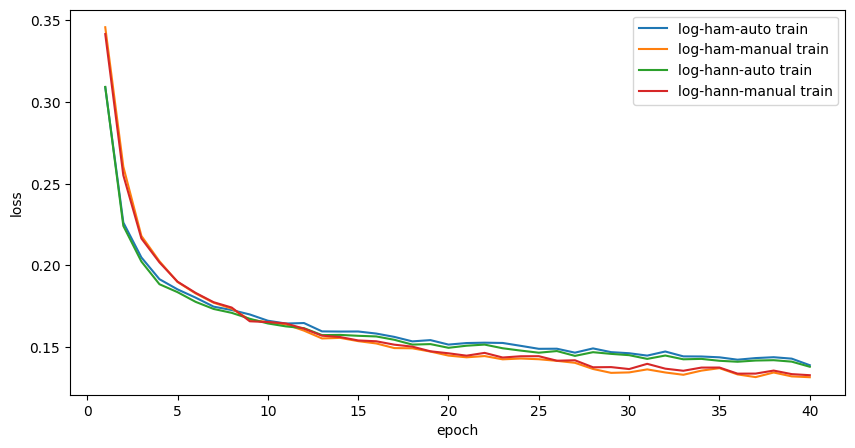

In [167]:
# Get path to folder containing logs 
log_folder = r'E:\tests\tests-20240118\spectro-hann\logs_copied'

files = glob.glob(log_folder  + "/*.csv")

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
#axes.set_ylim(0.1, 0.20)

for file in files:

    # Read the log file 
    log_file = pd.read_csv(file)

    labell = file.split('\\')[-1].split(".")[0]
    
    # Get the training and validation losses 
    tr_results = log_file[log_file['dataset']=='train']
    va_results = log_file[log_file['dataset']=='val']
    
    # Plot the loss curves 
    sns.lineplot(data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
    #sns.lineplot(data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto')  

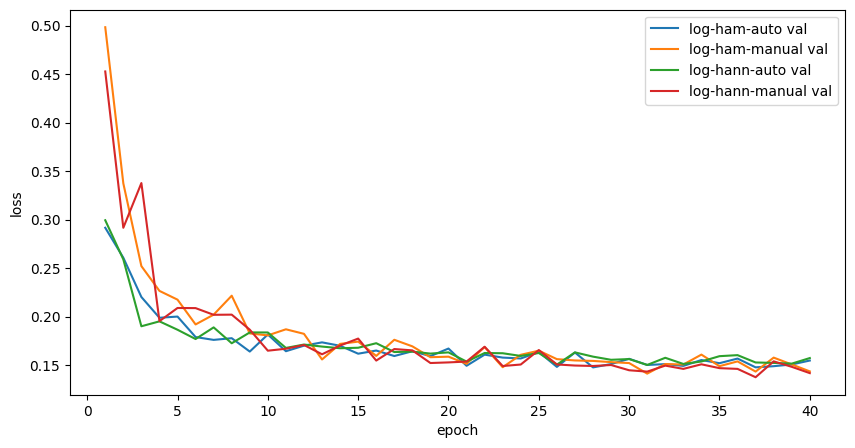

In [168]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
#axes.set_ylim(0.1, 0.20)

for file in files:

    # Read the log file 
    log_file = pd.read_csv(file)

    labell = file.split('\\')[-1].split(".")[0]
    
    # Get the training and validation losses 
    tr_results = log_file[log_file['dataset']=='train']
    va_results = log_file[log_file['dataset']=='val']
    
    # Plot the loss curves 
    #sns.lineplot(data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
    sns.lineplot(data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto')  

Manual dataset comes slightly out on top, run time is way less, hamming window wins slightly!

In [169]:
def compute_detections(labels, scores, threshold=0.5):

    # Compute the positive scores above threshold, 1 if it is above threshold, 0 if it is not 
    predictions = np.where(scores >= threshold, 1,0)

    # TP: Does the annotated label match the prediction above threshold? Bc "scores" is defined as the positive threshold, this represents TP
    TP = tf.math.count_nonzero(predictions * labels).numpy()

    # TN: Negative score is "predictions - 1" bc predictions was for the positive result, labels-1 so that the negatives are multiplied by 1
    TN = tf.math.count_nonzero((predictions - 1) * (labels - 1)).numpy()

    # And so on 
    FP = tf.math.count_nonzero(predictions * (labels - 1)).numpy()
    FN = tf.math.count_nonzero((predictions - 1) * labels).numpy()

    return predictions, TP, TN, FP, FN

In [170]:
def confusion_matrix_plot(cf, output_folder,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1, 1] / sum(cf[:, 1])
            recall = cf[1, 1] / sum(cf[1, :])
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        #plt.xlabel('Predicted label' + stats_text)
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)

    if title:
        #plt.title(title)
        #plt.title(stats_text)
        print('no title')

    plt.savefig(output_folder + '\\' + 'confusion_matrix.png')

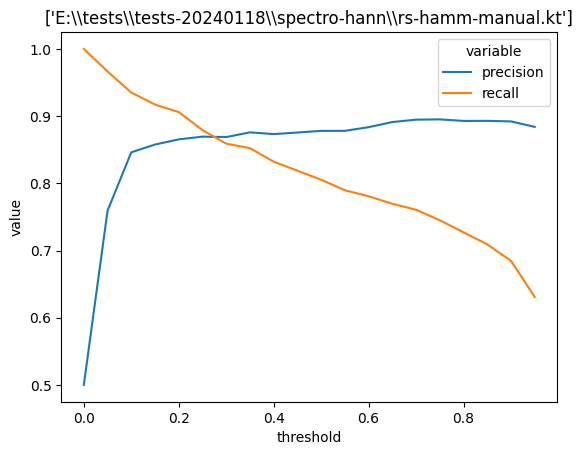

In [171]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = [r'E:\tests\tests-20240118\spectro-hann\metrics-manual-ham']
db_name = [r'E:\tests\tests-20240118\spectro-hann\hamm-manual.h5']
model_name = [r'E:\tests\tests-20240118\spectro-hann\rs-hamm-manual.kt']
temp_folder = [r'E:\tests\1sec-manual\spectro-tests\temp1', r'E:\tests\1sec-manual\spectro-tests\temp6']

for idex, model_name_idex in enumerate(model_name):

    # Open the database in read only file
    db = dbi.open_file(db_name[idex], 'r')
    
    # Open the table in the database at the root level
    table = dbi.open_table(db, '/test')
    
    classification_csv = "classifications.csv"
    metric_csv = "metrics.csv"
    stats_csv = "stats.csv"
    
    # Load the trained model
    model = ResNetInterface.load(model_name_idex, load_audio_repr=False, new_model_folder=temp_folder[idex])
    
    # Initialize Joint Batch Generator
    gens = []
    
    # Calculate the batch_size fixing the original batch size so there are no remainders
    batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))
    
    # for the testing dataset table in the database (or whatever table is passed in)
    for group in db.walk_nodes(table, "Table"):
        # Create a batch generator for this table
        generator = BatchGenerator(batch_size=batch_size, data_table=group,
                                   output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                                   refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)
    
        # Append the generator to the gens array
        gens.append(generator)
    
    # Create a joint batch generator if multiple tables are passed through
    gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)
    
    # Initialize the scores and labels
    scores = []
    labels = []
    
    # For each batch in the joint batch generator
    for batch_id in range(gen.n_batches):
        # Get the ids, spectrograms, and labels for the data in the batch
        hdf5_ids, batch_X, batch_Y = next(gen)
    
        # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
        batch_labels = np.argmax(batch_Y, axis=1)
    
        # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
        batch_scores = model.model.predict_on_batch(batch_X)[:, 1]
    
        # Add these scores for this batch to the overall list
        scores.extend(batch_scores)
        labels.extend(batch_labels)
    
    # Create a numpy array for the labels and scores for all batches
    labels = np.array(labels)
    scores = np.array(scores)
    
    df_groups = pd.DataFrame()
    df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall'])
    
    for threshold in thresholds:
    
        df_group = pd.DataFrame()
    
        # Compute the predictions, TP, TN, FP, and FN
        # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
        predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)
    
        # Create the "classifications" csv file
        for group in db.walk_nodes(table, "Table"):
            df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
            df_group = pd.concat([df_group, df], ignore_index=True)
        df_group['threshold'] = threshold
        df_group['label'] = labels[:]
        df_group['predicted'] = predicted[:]
        df_group['score'] = scores[:]
    
        # Calculate performance metrics
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        FPP = FP / (TN + FP)
    
        stats = [threshold, precision, recall]
    
        df_groups = pd.concat([df_groups, df_group])
        df_stats.loc[len(df_stats)] = stats
    
    df_groups.to_csv(os.path.join(os.getcwd(), output_dir[idex], classification_csv), mode='w', index=False)
    df_stats.to_csv(os.path.join(os.getcwd(), output_dir[idex], stats_csv), mode='w', index=False)
    
    sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
    plt.title(model_name)
    
    db.close()